# Imports and functions

In [6]:
from pyfoma import FST, State
from collections import Counter

def data_iterator(path):
    with open (path, "r") as fin:
        for line in fin.readlines():
            yield line.split()
            
    
def get_2_SL(strings:list[str]) -> list:
    return set([tuple(strings[i:i+2]) for i in range(len(strings)-1)])

def get_2_SP(strings:list[str]) -> set:
    sp = set()
    for i in range(len(strings)-1):
        sp = sp.union(set([(strings[i],strings[n]) for n in range(i+1, len(strings))]))
    return sp


for word in data_iterator("data/LearningData.txt"):
    pass







# Define the PFAs 

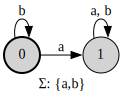

Help on class State in module pyfoma.fst:

class State(builtins.object)
 |  State(finalweight=None, name=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, finalweight=None, name=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_transition(self, other, label, weight)
 |      Add transition from self to other with label and weight.
 |  
 |  all_epsilon_targets_cheapest(self) -> dict
 |      Returns a dict of states a state transitions to (cheapest) with epsilon.
 |  
 |  all_targets(self) -> set
 |      Returns the set of states a state has transitions to.
 |  
 |  all_targets_cheapest(self) -> dict
 |      Returns a dict of states a state transitions to (cheapest).
 |  
 |  all_transitions(self)
 |      Generator for all transitions out from a given state.
 |  
 |  remove_transitions_to_targets(self, targets)
 |      Remove all transitions from self to any state in the set targets.
 |  
 |  rename_label(self, original, new)
 |      Chan